In [1]:
# !pip install -q segmentation_models_pytorch


In [3]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import cv2
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

import random
import torch
import torch.nn as nn
import albumentations

# import segmentation_models_pytorch as smp
import skimage

from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader,Dataset
from fastprogress import master_bar, progress_bar

def create_dir(path):
    if os.path.isdir(path)==False:
        os.makedirs(path)


In [4]:
# # CONFIGURE 

# # Set Data Paths
# test_path='test_satellite/'
# train_path='train_satellite/'
# labels_path='train_kelp/'


# # Create directories
# # test_predmask_path='test_kelp/'
# # create_dir(test_predmask_path)

# # set weights directory for new training saving
# weights_path='weights/'
# create_dir(weights_path)


# RETRAIN= False # if true retrain else use trained weights for inference
# trained_weights = 'trained_weights/' # meaningful only when RETRAIN=False


# # directory for prediction probabilities 
# test_preds_dir = 'test_preds/'
# create_dir(test_preds_dir)

from config import test_path, train_path, labels_path, weights_path, RETRAIN, trained_weights, test_preds_dir
# DO NOT EDIT BELOW

In [5]:
test_path, train_path, labels_path, weights_path, RETRAIN, trained_weights, test_preds_dir

('test_satellite/',
 'train_satellite/',
 'train_kelp/',
 'weights/',
 False,
 'trained_weights/',
 'test_preds/')

In [7]:
#Training parameters used
basename='kelp_UpperNet_512_full'

# training schedule variables
epochs=20
snapshots = 1
lr_0 = 0.0001
WARMUP_EPOCHS=2

# training input variables
SIZE=512 # resize image size
channels=[0,1,3] # SWIR, NIR, Green
meansCH = np.array( [0.485, 0.456, 0.406] )
stdsCH = np.array( [0.229, 0.224, 0.225] )
stdsCH *= 0.9
CLIPMIN=6000
CLIPMAX=24000


BA=3 # Batch Accumulation
num_workers = 4 # 
bs = 4 # Batch Size


In [5]:
test_image_names=os.listdir(test_path)
train_image_names=os.listdir(train_path)
mask_names = os.listdir(labels_path)
len(test_image_names),len(train_image_names),len(mask_names),test_image_names[0],mask_names[0]

(1426, 5635, 5635, 'FF979226_satellite.tif', 'WG210136_kelp.tif')

In [8]:
full_train_img_paths= np.array([train_path+x for x in train_image_names])
full_train_msk_paths= np.array([labels_path+x.split('_')[0]+'_kelp.tif' for x in train_image_names])
# full_test_img_paths= np.array([test_path+x for x in test_image_names])
# test_image_names=np.load('/kaggle/input/needkelp/kafe_test_image_names.npz')['arr_0']
full_test_img_paths=np.array([test_path+x for x in test_image_names])
len(full_train_img_paths),len(full_train_msk_paths),len(full_test_img_paths),full_train_img_paths[:2],full_test_img_paths[:2]


In [9]:
# vids=np.load('/kaggle/input/needkelp/valid_imids_ph2.npz')['arr_0']
# tids=np.load('/kaggle/input/needkelp/train_imids_ph2.npz')['arr_0']
# len(tids),len(vids)

# train_ids= np.array([train_path+x for x in tids])
# val_ids= np.array([train_path+x for x in vids])
# train_ids.shape, val_ids.shape

# train_ids=np.concatenate((train_ids,val_ids))

train_ids=np.array([train_path+x for x in train_image_names])
train_ids.shape,train_ids[:3]

In [9]:
from transformers import SwinConfig, UperNetConfig, UperNetForSemanticSegmentation
model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-convnext-tiny")
model.decode_head.classifier = torch.nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))

config.json:   0%|          | 0.00/8.76k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

In [12]:

def cosine_anneal_schedule(t):
    cos_inner = np.pi * (t % (epochs // snapshots))
    cos_inner /= epochs // snapshots
    cos_out = np.cos(cos_inner) + 1
    return float(lr_0 / 2 * cos_out)
cosine_anneal_schedule_list=[cosine_anneal_schedule(x) for x in range(epochs)]

cosine_anneal_schedule_list=[0.000001]*WARMUP_EPOCHS+cosine_anneal_schedule_list
epochs=len(cosine_anneal_schedule_list)
def adjust_optim(optimizer, n_iter):
    optimizer.param_groups[0]['lr'] = cosine_anneal_schedule_list[n_iter % epochs]



In [13]:

Ms = meansCH.mean()
Ss = stdsCH.mean()

class KelpDataset_disk(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(self, x_paths,y_paths, transforms=None, preprocessing=None, mode='train'):
        self.x_paths = x_paths
        self.y_paths = y_paths
        # self.ids = ids
        self.transforms = transforms
        self.preprocessing = preprocessing
        self.mode=mode

    def __len__(self):
        return len(self.x_paths)

    def __getitem__(self, idx):
        x_arr=tifffile.imread(self.x_paths[idx]).astype('float32')
        t=x_arr.copy()
        x_arr=np.clip(x_arr,CLIPMIN,CLIPMAX)
        x_arr[t<=-32000]=0
        del t

        if self.mode=='test':
            y_arr=np.zeros((350,350)).astype('uint8')
        else:
            y_arr=tifffile.imread(self.y_paths[idx])
        
        y_arr = np.expand_dims(y_arr, -1)
        
        if self.transforms:
            augmented = self.transforms(image=x_arr, mask=y_arr)
            x_arr, y_arr = augmented['image'], augmented['mask']
        # x_arr = np.transpose(x_arr, [2, 0, 1])
        
        x_arr = x_arr[...,channels]/CLIPMAX

        x_arr = (x_arr - meansCH)/stdsCH
        
        x_arr = np.transpose(x_arr, [2, 0, 1])
        y_arr = np.transpose(y_arr, [2, 0, 1])
        
        if self.preprocessing:
            preprocessed = self.preprocessing(image=x_arr, mask=y_arr)
            # preprocessed = self.preprocessing(image=x_arr)
            x_arr = preprocessed['image']
            y_arr = preprocessed['mask']

        return x_arr.astype('float32'), y_arr.astype('uint8')

In [14]:

training_transformations = albumentations.Compose(
    [
        albumentations.Resize(SIZE, SIZE),
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(),
        albumentations.VerticalFlip(),
    ]
)
validation_transformations = albumentations.Compose(
    [
        albumentations.Resize(SIZE, SIZE,),
    ]
)

In [15]:
# from sklearn.metrics import jaccard_score
def get_dice_coef(gt, preds, THRESH=0.5):
    dice = np.sum((preds>THRESH)[gt[:,0,...]==1])*2.0 / (np.sum((preds>THRESH)) + np.sum(gt[:,0,...]))
    return dice


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, eps=1e-7):
        
        # #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection )/(inputs.sum() + targets.sum() + eps)  
        
        return 1 - dice




In [10]:

name=basename
model.cuda()

if RETRAIN==True:

    optimizer = optim.AdamW(model.parameters(), lr=lr_0)




    train_dataset = KelpDataset_disk(x_paths=train_ids,
                                     y_paths=[x.replace('_satellite', '_kelp') for x in train_ids],
                                 transforms = training_transformations,
                                    )

    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)



    criterion1 = DiceLoss()

    device = "cuda"
    best_score=0.

    mb = master_bar(range(epochs))
    loss_log=[]
    for epoch in mb:
        avg_train_loss = 0.
        model.train()    

        pb = progress_bar(train_loader)
        for ii, (data, target) in enumerate(pb):

            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)

           # optimizer.zero_grad()
            output = model(data)
            output=output.logits
            output=torch.sigmoid(output)

            # loss = criterion1(output, target.long())
            loss = criterion1(output, target.to(dtype=torch.float)).mean()


            loss.backward()
            if (ii + 1) % BA == 0:            
                optimizer.step()
                optimizer.zero_grad()
            # optimizer.step()
            if ii % 1000 == 0:
                loss_log.append(loss.item())
            avg_train_loss += loss.item() / len(train_loader)

        print('Epoch: {} - Loss: {:.6f}'.format(epoch + 1, avg_train_loss))

        adjust_optim(optimizer, (epoch + 1))

        gc.collect()

    torch.save(model.state_dict(), weights_path+name+'_last.pt')
else:
    model.load_state_dict(torch.load(  trained_weights+basename+'_last.pt') )
    

In [17]:
model.eval()
print('model eval')

model eval


In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [19]:
gc.collect()

0

In [20]:
test_dataset = KelpDataset_disk(x_paths=full_test_img_paths,
                                y_paths=None,
                             transforms = validation_transformations,
                             # preprocessing=get_preprocessing(preprocessing_fn)
                                 mode='test'
                                )

test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)


In [21]:
test_preds = np.zeros((len(full_test_img_paths), SIZE,SIZE))
with torch.no_grad():

    test_preds1 =[]
    test_preds2 =[]
    test_preds3 =[]
    test_preds4 =[]

    counter=0
    pb = progress_bar(test_loader)
    for i, (x_batch, y_batch) in enumerate(pb):

        preds1 = model(x_batch.cuda(non_blocking=True)).logits.detach().cpu().numpy()
        preds2 = model(torch.flip(x_batch, dims=[2]).cuda(non_blocking=True)).logits.detach().cpu().numpy()
        preds3 = model(torch.flip(x_batch, dims=[3]).cuda(non_blocking=True)).logits.detach().cpu().numpy()
        preds4 = model(torch.flip(x_batch, dims=[2,3]).cuda(non_blocking=True)).logits.detach().cpu().numpy()


        test_preds[counter*len(x_batch):(counter+1)*len(x_batch),...]=((preds1+preds2[...,::-1,:]+
                                                        preds3[...,:,::-1]+preds4[...,::-1,::-1])/4)[:,0,...]
        counter+=1
        


In [22]:
test_preds=sigmoid(test_preds)

In [23]:
np.savez(test_preds_dir+'testprobs_kk_'+basename, test_preds.astype('float16'))


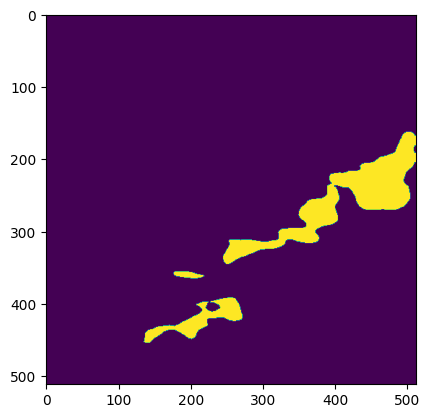

In [24]:
plt.imshow(test_preds[1]>0.5)
plt.show()

In [11]:
# test_preds = np.array([skimage.transform.resize(x, (350,350)) for x in test_preds])
# test_preds.shape

In [12]:
# THRESH=0.5
# test_preds = np.array([(x>THRESH).astype('uint8') for x in test_preds])

In [13]:
# [cv2.imwrite(test_predmask_path+test_image_names[i].split('_')[0]+'_kelp.tif', test_preds[i])
#  for i in range(len(test_preds))]
# print('saved in disk')

In [14]:
# !cd test_kelp && zip -rq subm.zip *

In [15]:
# !du -h subm.zip